In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path ='/content/drive/MyDrive/dataset/chest/chest_xray/train'

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(degrees=(-40, 40)),
        transforms.RandomResizedCrop(299),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}


In [ ]:
from torchvision.datasets import ImageFolder
combined_dataset = ImageFolder(root=dataset_path, transform=data_transforms['train'])

In [ ]:
train_size = int(0.8 * len(combined_dataset))
val_size = len(combined_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(combined_dataset, [train_size, val_size])

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=5, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=5, shuffle=False)

In [ ]:
num_iterations = len(train_loader)
print("Number of iterations:", num_iterations)

Number of iterations: 836


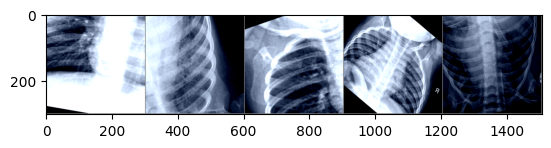

Labels: tensor([0, 1, 0, 0, 1])


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, models, transforms, utils
inputs, labels = next(iter(train_loader))
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
imshow(utils.make_grid(inputs))
print('Labels:', labels)

In [ ]:
for images, labels in train_loader:
    print(images.size())
    break

torch.Size([5, 3, 299, 299])


In [ ]:
import os
normal_folder = os.path.join(dataset_path, 'NORMAL')
pneumonia_folder = os.path.join(dataset_path, 'PNEUMONIA')
print("Normal Samples:", len(os.listdir(normal_folder)))
print("Pneumonia Samples:", len(os.listdir(pneumonia_folder)))


Normal Samples: 1341
Pneumonia Samples: 3875


In [ ]:
for batch, labels in train_loader:
    print("Batch Shape:", batch.shape)
    print("Labels:", labels)
    break

Batch Shape: torch.Size([5, 3, 299, 299])
Labels: tensor([1, 0, 1, 1, 1])


In [ ]:
import torch.nn as nn
class ChestXRayEncoder(nn.Module):
    def __init__(self):
        super(ChestXRayEncoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.global_pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, weight, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        return x

encoder = ChestXRayEncoder()
weight = torch.randn(256)
for batch, labels in train_loader:
    features = encoder(weight, batch)
    print("Encoded Features Shape:", features.shape)
    break

Encoded Features Shape: torch.Size([5, 256])


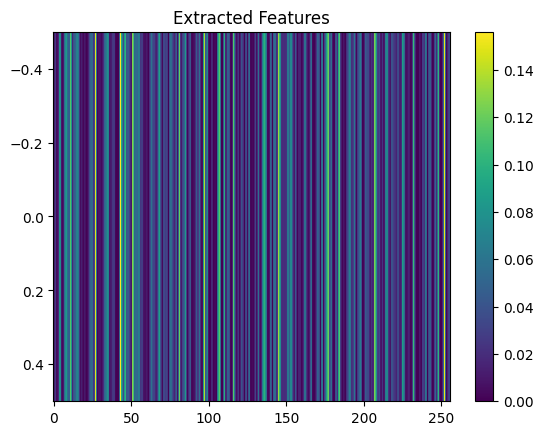

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
features_np = features.detach().cpu().numpy()  # Convert to NumPy array
feature_image = features_np[0]
plt.imshow(feature_image.reshape(1, -1), cmap='viridis', aspect='auto')  # Assuming the features are 1D
plt.colorbar()
plt.title('Extracted Features')
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class AACoder(nn.Module):
    def __init__(self, input_size, noise_size, output_size):
        super(AACoder, self).__init__()
        self.fc1 = nn.Linear(input_size + noise_size, output_size)
        self.fc2 = nn.Linear(output_size, input_size)

    def forward(self, original_features, gaussian_noise, weight):
        combined_features = torch.cat((original_features, gaussian_noise), dim=1)
        x = F.relu(self.fc1(combined_features))
        x = self.fc2(x)
        return x
input_size = features.size(1)
noise_size = 100
output_size = 256
aacoder = AACoder(input_size, noise_size, output_size)
gaussian_noise = torch.randn(features.size(0), noise_size)
aacoder_weight = torch.randn(output_size)
attack_features = aacoder(features, gaussian_noise, aacoder_weight)
print("Attack Features Shape:", attack_features.shape)

Attack Features Shape: torch.Size([5, 256])


In [ ]:
import torch
import torch.nn as nn
class ReconstructionBlock(nn.Module):
    def __init__(self, input_size, output_size):
        super(ReconstructionBlock, self).__init__()
        self.fc = nn.Linear(input_size, output_size)
    def forward(self, input_features):
        return self.fc(input_features)
class AttentionBlock(nn.Module):
    def __init__(self, input_size, output_size):
        super(AttentionBlock, self).__init__()
        self.fc = nn.Linear(input_size, output_size)
        self.sigmoid = nn.Sigmoid()
    def forward(self, classification_features):
        attention_features = self.sigmoid(self.fc(classification_features))
        return attention_features
class CombineBlock(nn.Module):
    def __init__(self):
        super(CombineBlock, self).__init__()
    def forward(self, perturbation_restoration, attention_features):
        final_perturbation = perturbation_restoration * attention_features
        return final_perturbation
class Decoder(nn.Module):
    def __init__(self, reconstruction_input_size, attention_input_size, perturbation_restoration_output_size):
        super(Decoder, self).__init__()
        self.reconstruction_block = ReconstructionBlock(reconstruction_input_size, perturbation_restoration_output_size)
        self.attention_block = AttentionBlock(attention_input_size, perturbation_restoration_output_size)
        self.combine_block = CombineBlock()
    def forward(self, classification_features, attack_features):
        attention_features = self.attention_block(classification_features)
        perturbation_restoration = self.reconstruction_block(attack_features)
        final_perturbation = self.combine_block(perturbation_restoration, attention_features)
        return final_perturbation
chest_xray_encoder_output_size = 256
aacoder_output_size = 256
decoder_output_size = 1280
reconstruction_input_size = aacoder_output_size
attention_input_size = chest_xray_encoder_output_size
perturbation_restoration_output_size = decoder_output_size
decoder = Decoder(reconstruction_input_size, attention_input_size, perturbation_restoration_output_size)
classification_features = torch.randn(5, attention_input_size)
attack_features = torch.randn(5, reconstruction_input_size)
final_perturbation = decoder(classification_features, attack_features)
print("Final Perturbation Shape:", final_perturbation.shape)

Final Perturbation Shape: torch.Size([5, 1280])


In [ ]:
import torch
import torch.nn as nn
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = x / torch.max(torch.abs(x))
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
def wasserstein_distance(features1, features2):
    w_distance = torch.mean(features1 - features2)
    return w_distance

In [ ]:
threshold = 0.5
for i, (batch, labels) in enumerate(train_loader):
    original_features = encoder(weight, batch)
    gaussian_noise = torch.randn(original_features.size(0), noise_size)
    attack_features = aacoder(original_features, gaussian_noise, aacoder_weight)
    restored_perturbations = decoder(original_features, attack_features)
    restored_perturbations_reshaped = restored_perturbations.view(restored_perturbations.size(0), -1, 1, 1)
    num_channels_original = batch.size(1)
    num_channels_perturbations = restored_perturbations_reshaped.size(1)
    if num_channels_original != num_channels_perturbations:
        restored_perturbations_reshaped = restored_perturbations_reshaped[:, :num_channels_original, :, :]
    adversarial_samples = batch + restored_perturbations_reshaped
    flattened_samples = adversarial_samples.view(adversarial_samples.size(0), -1)
    input_size = flattened_samples.size(1)
    hidden_size = 128
    output_size = 1
    discriminator = Discriminator(input_size, hidden_size, output_size)
    discriminator_output = discriminator(flattened_samples)
    w_distance = wasserstein_distance(original_features, discriminator_output)
    classified_sample = "real" if w_distance <= threshold else "fake"
    for j in range(len(batch)):
        print(f"Batch {i+1}, Adversarial Sample {j+1}: {classified_sample}")
    break

Batch 1, Adversarial Sample 1: fake
Batch 1, Adversarial Sample 2: fake
Batch 1, Adversarial Sample 3: fake
Batch 1, Adversarial Sample 4: fake
Batch 1, Adversarial Sample 5: fake


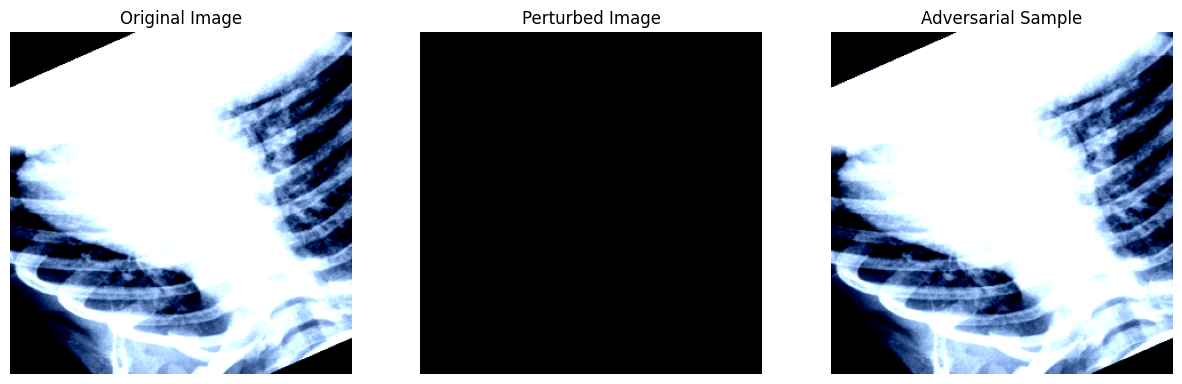

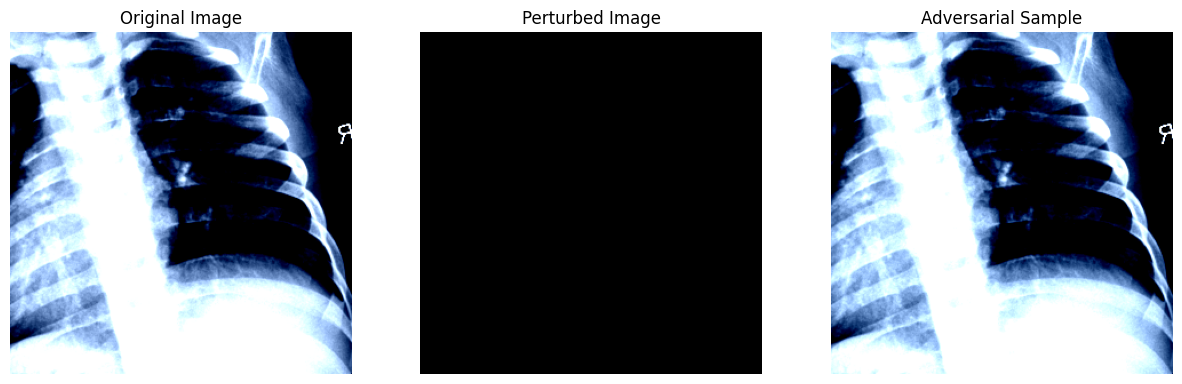

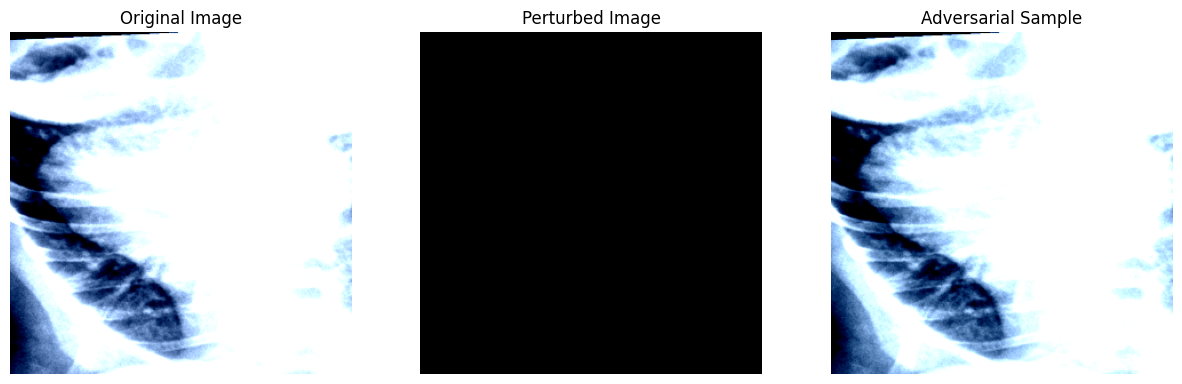

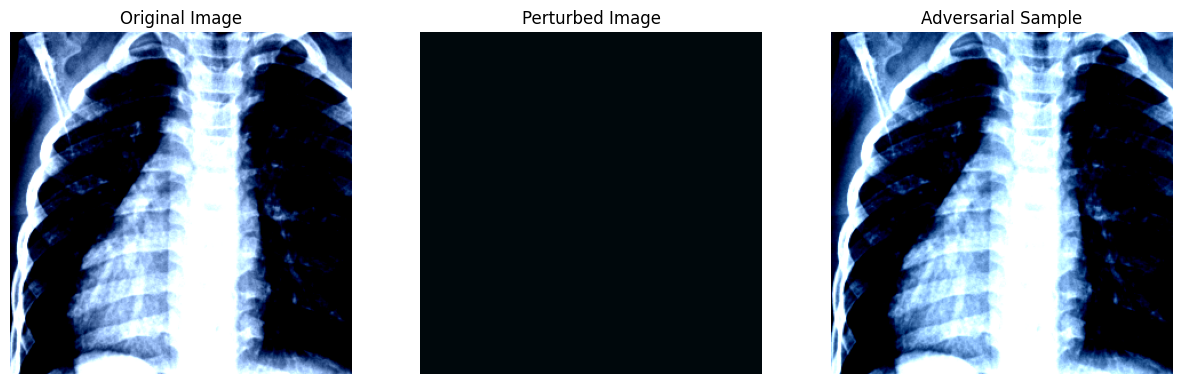

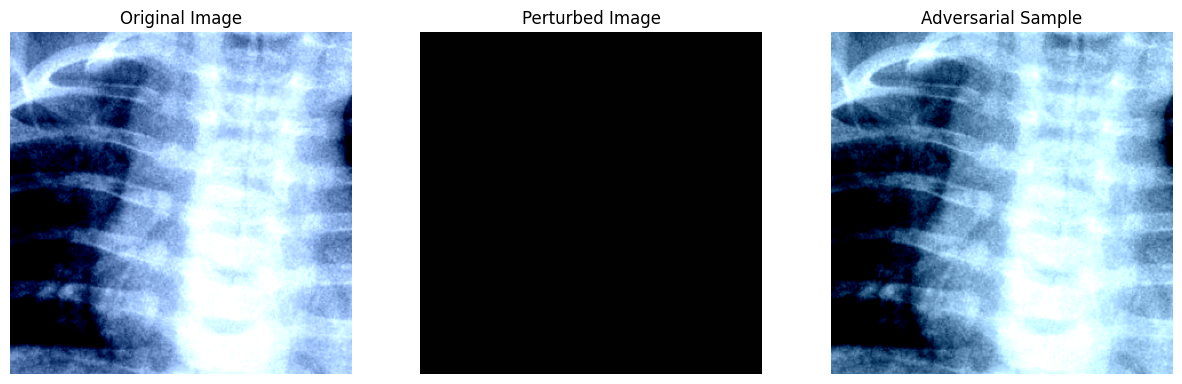

In [ ]:
def visualize_samples(original, perturbed, adversarial):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    titles = ['Original Image', 'Perturbed Image', 'Adversarial Sample']
    samples = [original, perturbed, adversarial]
    for ax, title, sample in zip(axes, titles, samples):
        ax.imshow(np.transpose(sample.detach().numpy(), (1, 2, 0)))
        ax.set_title(title)
        ax.axis('off')
    plt.show()
for batch, labels in train_loader:
    original_features = encoder(weight, batch)
    gaussian_noise = torch.randn(original_features.size(0), noise_size)
    attack_features = aacoder(original_features, gaussian_noise, aacoder_weight)
    restored_perturbations = decoder(original_features, attack_features)
    restored_perturbations_reshaped = restored_perturbations.view(restored_perturbations.size(0), -1, 1, 1)
    num_channels_original = batch.size(1)
    num_channels_perturbations = restored_perturbations_reshaped.size(1)
    if num_channels_original != num_channels_perturbations:
        restored_perturbations_reshaped = restored_perturbations_reshaped[:, :num_channels_original, :, :]
    adversarial_samples = batch + restored_perturbations_reshaped
    for i in range(len(batch)):
        visualize_samples(batch[i], restored_perturbations_reshaped[i], adversarial_samples[i])
    break

In [ ]:
import torch
import torchvision.models as models
wrn50 = models.wide_resnet50_2(pretrained=True)
vgg19 = models.vgg19(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth
100%|██████████| 132M/132M [00:02<00:00, 46.6MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated sinc

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
num_classes = 2
wrn50.fc = torch.nn.Linear(wrn50.fc.in_features, num_classes)
vgg19.classifier[6] = torch.nn.Linear(vgg19.classifier[6].in_features, num_classes)
wrn50.eval()
vgg19.eval()
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
def classify_image(image, model):
    image = Variable(image.unsqueeze(0))
    output = model(image)
    _, predicted = torch.max(output.data, 1)
    return predicted.item()
for batch, labels in train_loader:
    wrn50_predictions = []
    for sample in adversarial_samples:
        wrn50_pred = classify_image(sample, wrn50)
        wrn50_predictions.append(wrn50_pred)
    vgg19_predictions = []
    for sample in adversarial_samples:
        vgg19_pred = classify_image(sample, vgg19)
        vgg19_predictions.append(vgg19_pred)
    class_labels = {0: 'Normal', 1: 'Pneumonia'}
    for i, (wrn50_pred, vgg19_pred) in enumerate(zip(wrn50_predictions, vgg19_predictions)):
        wrn50_class = class_labels[wrn50_pred]
        vgg19_class = class_labels[vgg19_pred]
        print(f"Adversarial Sample {i+1}: WRN-50 predicted label: {wrn50_class}, VGG-19 predicted label: {vgg19_class}")
    break

Adversarial Sample 1: WRN-50 predicted label: Pneumonia, VGG-19 predicted label: Normal
Adversarial Sample 2: WRN-50 predicted label: Pneumonia, VGG-19 predicted label: Normal
Adversarial Sample 3: WRN-50 predicted label: Normal, VGG-19 predicted label: Pneumonia
Adversarial Sample 4: WRN-50 predicted label: Pneumonia, VGG-19 predicted label: Pneumonia
Adversarial Sample 5: WRN-50 predicted label: Normal, VGG-19 predicted label: Normal


In [ ]:
import torch
import torch.nn.functional as F
alpha = 1.0
beta = 1.0
gamma = 1.0
c = 0.1
def calculate_adversarial_classification_loss(outputs, labels):
    return F.cross_entropy(outputs, labels)
def calculate_adversarial_generation_loss(discriminator_outputs):
    return torch.mean(1 - discriminator_outputs)
def calculate_perturbation_magnitude_loss(perturbation):
    return torch.mean(torch.max(torch.tensor(0.0), torch.norm(perturbation, p=2) - c))
def calculate_feature_consistency_loss(features_original, features_perturbed):
    return F.mse_loss(features_original, features_perturbed)
wrn = models.wide_resnet50_2(pretrained=True)
vgg19 = models.vgg19(pretrained=True
num_classes = 2
wrn.fc = torch.nn.Linear(wrn.fc.in_features, num_classes)
vgg19.classifier[6] = torch.nn.Linear(vgg19.classifier[6].in_features, num_classes)
wrn.eval()
vgg19.eval()
for batch, labels in train_loader:
    original_features = encoder(weight, batch)
    gaussian_noise = torch.randn(original_features.size(0), noise_size)
    attack_features = aacoder(original_features, gaussian_noise, aacoder_weight)
    restored_perturbations = decoder(original_features, attack_features)
    restored_perturbations_reshaped = restored_perturbations.view(restored_perturbations.size(0), -1, 1, 1)
    num_channels_original = batch.size(1)
    num_channels_perturbations = restored_perturbations_reshaped.size(1)
    if num_channels_original != num_channels_perturbations:
        restored_perturbations_reshaped = restored_perturbations_reshaped[:, :num_channels_original, :, :]
    adversarial_samples = batch + restored_perturbations_reshaped
    wrn_outputs = wrn(adversarial_samples)
    vgg19_outputs = vgg19(adversarial_samples)
    loss_wrn = calculate_adversarial_classification_loss(wrn_outputs, labels)
    loss_vgg19 = calculate_adversarial_classification_loss(vgg19_outputs, labels)
    print("Adversarial Classification Loss (WRN):", loss_wrn.item())
    print("Adversarial Classification Loss (VGG-19):", loss_vgg19.item())
    break

Adversarial Classification Loss (WRN): 0.7093392610549927
Adversarial Classification Loss (VGG-19): 0.7746350169181824


In [ ]:
import numpy as np
def calculate_l2_norm(original_images, adversarial_samples):
    l2_norms = []
    for original_image, adversarial_sample in zip(original_images, adversarial_samples):
        perturbation = adversarial_sample - original_image
        l2_norm = np.linalg.norm(perturbation)
        l2_norms.append(l2_norm)
    return l2_norms

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np
wrn = models.wide_resnet50_2(pretrained=True)
vgg19 = models.vgg19(pretrained=True)
wrn.eval()
vgg19.eval()
for batch, labels in train_loader:
    wrn_outputs = wrn(batch)
    vgg19_outputs = vgg19(batch)
    wrn_preds = torch.argmax(wrn_outputs, dim=1).cpu().numpy()
    vgg19_preds = torch.argmax(vgg19_outputs, dim=1).cpu().numpy()
    accuracy_wrn = accuracy_score(labels.cpu().numpy(), wrn_preds)
    accuracy_vgg19 = accuracy_score(labels.cpu().numpy(), vgg19_preds)
    auc_wrn = roc_auc_score(labels.cpu().numpy(), wrn_outputs[:, 1].detach().cpu().numpy())
    auc_vgg19 = roc_auc_score(labels.cpu().numpy(), vgg19_outputs[:, 1].detach().cpu().numpy())
    l2_norm_wrn = calculate_l2_norm(batch.detach().cpu().numpy(), adversarial_samples.detach().cpu().numpy())
    l2_norm_vgg19 = calculate_l2_norm(batch.detach().cpu().numpy(), adversarial_samples.detach().cpu().numpy())
    print("Accuracy (WRN, VGG-19):", accuracy_wrn, accuracy_vgg19)
    print("AUC (WRN, VGG-19):", auc_wrn, auc_vgg19)
    print("L2 Norm (WRN):", l2_norm_wrn)
    print("L2 Norm (VGG-19):", l2_norm_vgg19)

Accuracy (WRN, VGG-19): 0.0 0.0
AUC (WRN, VGG-19): 0.0 0.0
L2 Norm (WRN): [620.12665, 520.3943, 1048.2438, 567.13965, 448.64133]
L2 Norm (VGG-19): [620.12665, 520.3943, 1048.2438, 567.13965, 448.64133]


In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np
wrn.eval()
vgg19.eval()
for batch, labels in train_loader:
    wrn_outputs = wrn(batch)
    vgg19_outputs = vgg19(batch)
    wrn_preds = torch.argmax(wrn_outputs, dim=1).cpu().numpy()
    vgg19_preds = torch.argmax(vgg19_outputs, dim=1).cpu().numpy()
    accuracy_wrn = accuracy_score(labels.cpu().numpy(), wrn_preds)
    accuracy_vgg19 = accuracy_score(labels.cpu().numpy(), vgg19_preds)
    print("Accuracy (WRN, VGG-19):", accuracy_wrn, accuracy_vgg19)
    break

Accuracy (WRN, VGG-19): 0.0 0.0


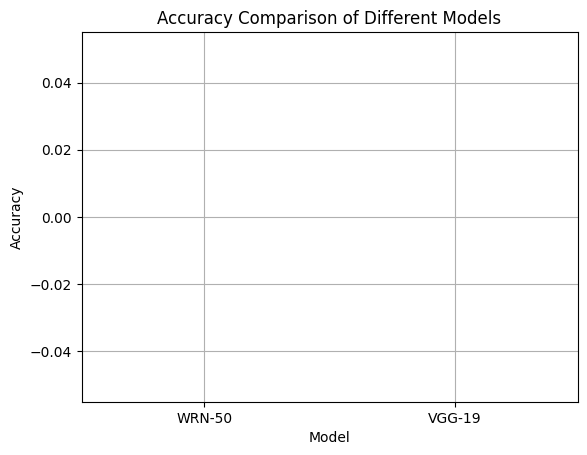

In [ ]:
import matplotlib.pyplot as plt
models = ['WRN-50', 'VGG-19']
accuracies = [accuracy_wrn, accuracy_vgg19]
plt.bar(models, accuracies, color=['blue', 'green'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Different Models')
plt.grid(True)
plt.show()
